In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Transformations applied on each image
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to tensor format
    transforms.Normalize((0.5,), (0.5,))  # Normalize the images
])

# Loading the training data
train_data = datasets.FashionMNIST(
    root='data',
    train=True,
    download=True,
    transform=transform
)

# Loading the test data
test_data = datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=transform
)

# Creating data loaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)


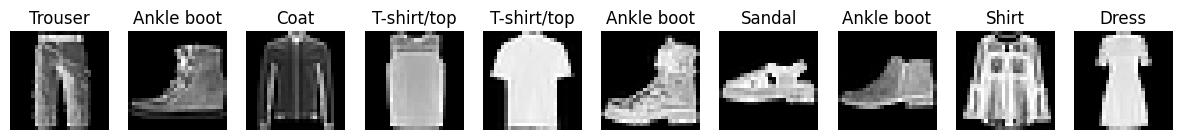

In [2]:
import matplotlib.pyplot as plt

# Class labels in FashionMNIST
class_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

def show_images(images, labels, n=10):
    plt.figure(figsize=(15, 15))
    for i in range(n):
        plt.subplot(1, n, i+1)
        plt.imshow(images[i].numpy().squeeze(), cmap='gray')
        plt.title(class_labels[labels[i]])
        plt.axis('off')
    plt.show()

# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Display images
show_images(images, labels)


In [3]:
import torch.nn as nn
import torch.nn.functional as F

class FashionClassifier(nn.Module):
    def __init__(self):
        super(FashionClassifier, self).__init__()
        self.fc1 = nn.Linear(28*28, 256)  # Flatten the image and input to the first layer
        self.fc2 = nn.Linear(256, 128)    # Second layer
        self.fc3 = nn.Linear(128, 10)     # Output layer with 10 classes

    def forward(self, x):
        x = x.view(-1, 28*28)  # Flatten the image
        x = F.relu(self.fc1(x))  # Activation function for the first layer
        x = F.relu(self.fc2(x))  # Activation function for the second layer
        x = self.fc3(x)  # Output logits
        return x

# Instantiate the model
model = FashionClassifier()
print(model)


FashionClassifier(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


Epoch 1/10.. Train loss: 0.489.. Val loss: 0.442.. Val F1: 0.822
Epoch 2/10.. Train loss: 0.364.. Val loss: 0.402.. Val F1: 0.839
Epoch 3/10.. Train loss: 0.328.. Val loss: 0.368.. Val F1: 0.855
Epoch 4/10.. Train loss: 0.301.. Val loss: 0.350.. Val F1: 0.859
Epoch 5/10.. Train loss: 0.284.. Val loss: 0.356.. Val F1: 0.862
Epoch 6/10.. Train loss: 0.267.. Val loss: 0.348.. Val F1: 0.867
Epoch 7/10.. Train loss: 0.254.. Val loss: 0.331.. Val F1: 0.871
Epoch 8/10.. Train loss: 0.241.. Val loss: 0.345.. Val F1: 0.872
Epoch 9/10.. Train loss: 0.231.. Val loss: 0.355.. Val F1: 0.868
Epoch 10/10.. Train loss: 0.219.. Val loss: 0.347.. Val F1: 0.872


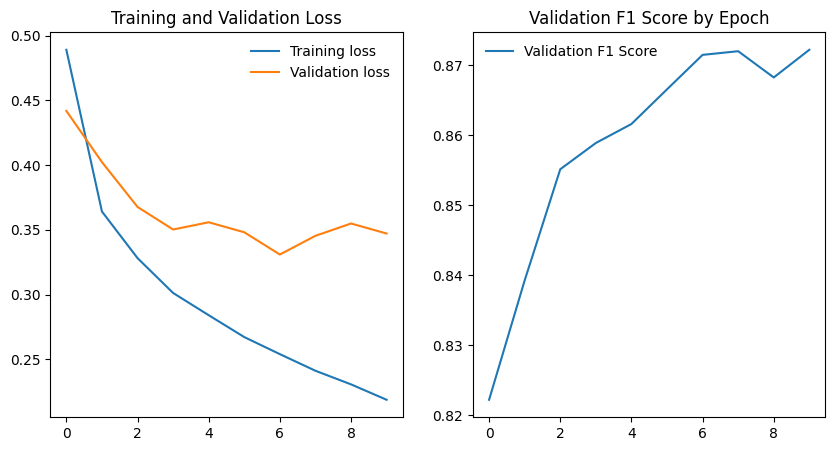

In [4]:
from torch import optim
import numpy as np
from sklearn.metrics import f1_score

# Check if GPU is available and set the device accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the model to the chosen device
model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Number of epochs to train for
num_epochs = 10

# To keep track of training and validation losses and F1-scores
train_losses, val_losses, val_f1_scores = [], [], []

for epoch in range(num_epochs):
    running_loss = 0
    model.train()  # Set the model to training mode
    
    # Training loop
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()  # Zero the parameter gradients
        log_ps = model(images)  # Forward pass
        loss = criterion(log_ps, labels)
        loss.backward()  # Backward pass
        optimizer.step()
        
        running_loss += loss.item()
    
    else:
        val_loss = 0
        total_f1_score = 0
        num_batches = 0
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            model.eval()  # Set the model to evaluation mode
            
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                log_ps = model(images)
                val_loss += criterion(log_ps, labels).item()
                
                # Calculate accuracy
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy = torch.mean(equals.type(torch.FloatTensor)).item()
                
                # Calculate F1 score
                preds = top_class.view(-1).cpu().numpy()  # Get the predicted classes
                true = labels.view(-1).cpu().numpy()  # Get the true classes
                total_f1_score += f1_score(true, preds, average='macro')
                num_batches += 1

        # Calculate average losses and f1 score
        train_losses.append(running_loss/len(train_loader))
        val_losses.append(val_loss/len(test_loader))
        val_f1_scores.append(total_f1_score/num_batches)

        # Print training and validation results
        print(f'Epoch {epoch+1}/{num_epochs}.. '
              f'Train loss: {train_losses[-1]:.3f}.. '
              f'Val loss: {val_losses[-1]:.3f}.. '
              f'Val F1: {val_f1_scores[-1]:.3f}')

# Plot training and evaluation history
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend(frameon=False)

plt.subplot(1, 2, 2)
plt.plot(val_f1_scores, label='Validation F1 Score')
plt.title('Validation F1 Score by Epoch')
plt.legend(frameon=False)
plt.show()


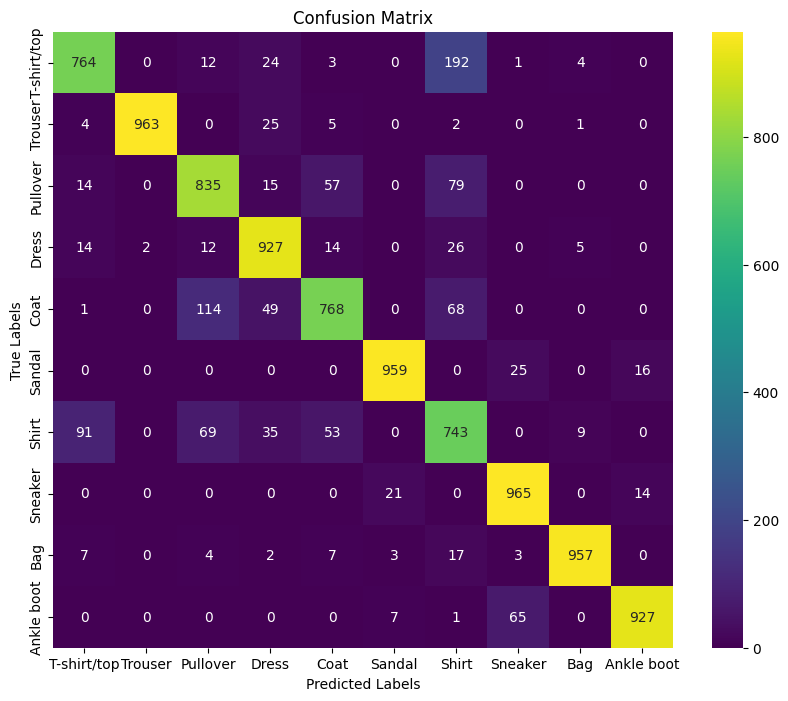

In [5]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Containers for all predictions and true labels
all_preds = []
all_labels = []

# Evaluate the model on the test set
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds, labels=range(len(class_labels)))

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='viridis', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [6]:
class FashionCNN(nn.Module):
    def __init__(self):
        super(FashionCNN, self).__init__()
        # First convolutional layer: 1 input channel (grayscale image), 32 output channels, kernel size of 3
        self.conv1 = nn.Conv2d(1, 32, 3, 1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1, padding=1)
        self.fc1 = nn.Linear(7*7*64, 128)  # after two pooling layers, the image size is reduced to 7x7
        self.fc2 = nn.Linear(128, 10)
        self.pool = nn.MaxPool2d(2, 2)  # Pooling layer with size 2 and stride 2
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # Flatten the tensor for the fully connected layer
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate the CNN model
cnn_model = FashionCNN().to(device)
print(cnn_model)

FashionCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
)


In [7]:
# Re-define the optimizer since we now have a different model
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
train_losses_cnn, val_losses_cnn, val_f1_scores_cnn = [], [], []

for epoch in range(num_epochs):
    running_loss = 0
    cnn_model.train()  # Training mode

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        log_ps = cnn_model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

    # Validation
    val_loss = 0
    total_f1_score = 0
    num_batches = 0
    
    with torch.no_grad():
        cnn_model.eval()
        
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            log_ps = cnn_model(images)
            val_loss += criterion(log_ps, labels).item()
            
            _, predicted = torch.max(log_ps, 1)
            preds = predicted.cpu().numpy()
            true = labels.cpu().numpy()
            total_f1_score += f1_score(true, preds, average='macro')
            num_batches += 1

    train_losses_cnn.append(running_loss/len(train_loader))
    val_losses_cnn.append(val_loss/len(test_loader))
    val_f1_scores_cnn.append(total_f1_score/num_batches)

    print(f'Epoch {epoch+1}/{num_epochs}.. '
          f'Train loss: {train_losses_cnn[-1]:.3f}.. '
          f'Val loss: {val_losses_cnn[-1]:.3f}.. '
          f'Val F1: {val_f1_scores_cnn[-1]:.3f}')


Epoch 1/10.. Train loss: 0.443.. Val loss: 0.329.. Val F1: 0.869
Epoch 2/10.. Train loss: 0.295.. Val loss: 0.302.. Val F1: 0.883
Epoch 3/10.. Train loss: 0.250.. Val loss: 0.259.. Val F1: 0.896
Epoch 4/10.. Train loss: 0.220.. Val loss: 0.245.. Val F1: 0.901
Epoch 5/10.. Train loss: 0.198.. Val loss: 0.235.. Val F1: 0.907
Epoch 6/10.. Train loss: 0.179.. Val loss: 0.226.. Val F1: 0.913
Epoch 7/10.. Train loss: 0.161.. Val loss: 0.225.. Val F1: 0.914
Epoch 8/10.. Train loss: 0.145.. Val loss: 0.222.. Val F1: 0.915
Epoch 9/10.. Train loss: 0.134.. Val loss: 0.240.. Val F1: 0.913
Epoch 10/10.. Train loss: 0.119.. Val loss: 0.243.. Val F1: 0.913


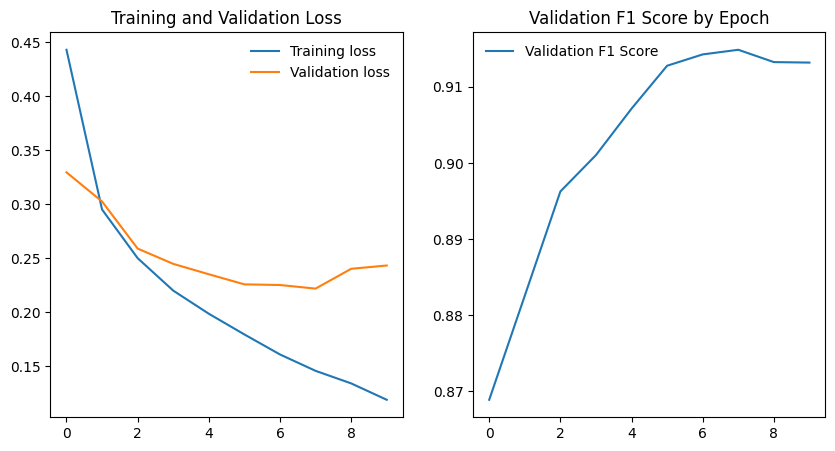

In [8]:
# Plot training and evaluation history
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses_cnn, label='Training loss')
plt.plot(val_losses_cnn, label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend(frameon=False)

plt.subplot(1, 2, 2)
plt.plot(val_f1_scores_cnn, label='Validation F1 Score')
plt.title('Validation F1 Score by Epoch')
plt.legend(frameon=False)
plt.show()

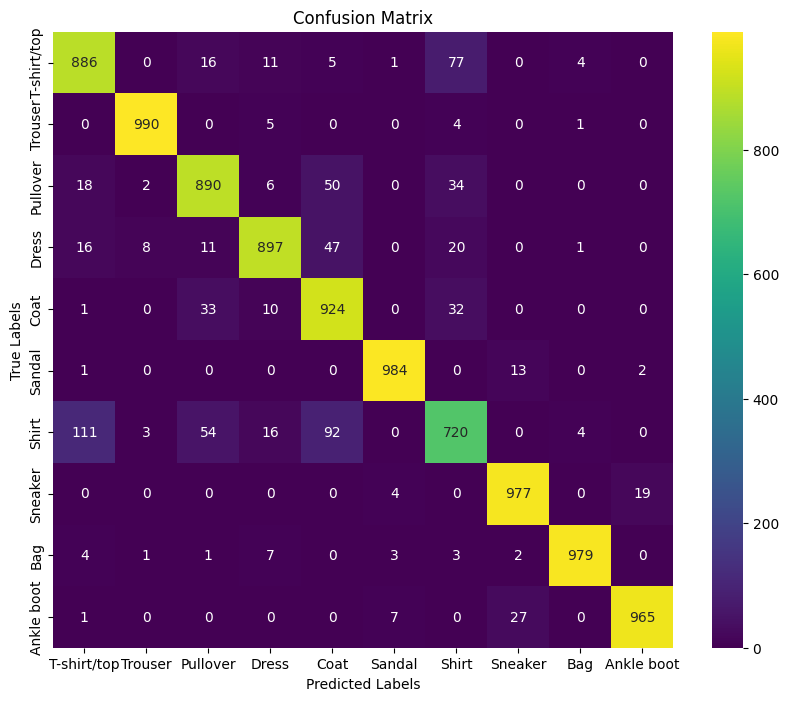

In [9]:
# Containers for all predictions and true labels
all_preds_cnn = []
all_labels_cnn = []

# Evaluate the model on the test set
cnn_model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = cnn_model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds_cnn.extend(predicted.cpu().numpy())
        all_labels_cnn.extend(labels.cpu().numpy())

# Compute the confusion matrix
conf_matrix = confusion_matrix(all_labels_cnn, all_preds_cnn, labels=range(len(class_labels)))

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='viridis', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


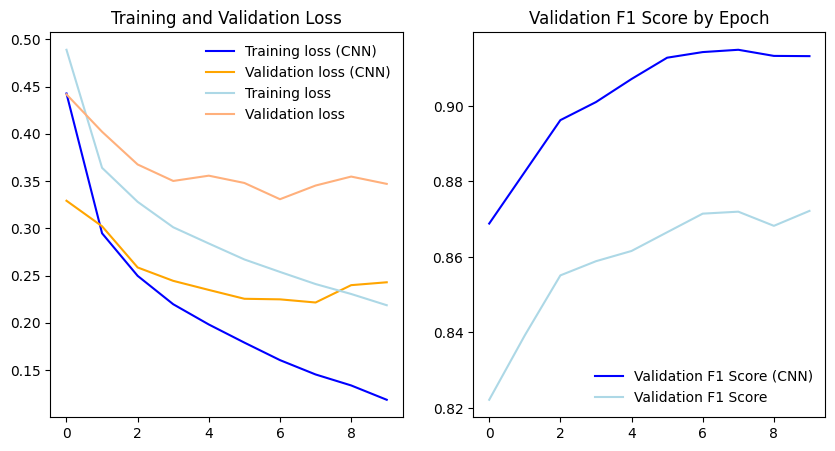

In [13]:
# Plot training and evaluation history
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses_cnn, label='Training loss (CNN)', color="blue")
plt.plot(val_losses_cnn, label='Validation loss (CNN)', color="orange")
plt.plot(train_losses, label='Training loss', color="lightblue")
plt.plot(val_losses, label='Validation loss', color="xkcd:peach")
plt.title('Training and Validation Loss')
plt.legend(frameon=False)

plt.subplot(1, 2, 2)
plt.plot(val_f1_scores_cnn, label='Validation F1 Score (CNN)', color="blue")
plt.plot(val_f1_scores, label='Validation F1 Score', color="lightblue")
plt.title('Validation F1 Score by Epoch')
plt.legend(frameon=False)
plt.show()